## Assignment 6 - Information retrieval using Speech data

## 1. Data Collection:

Use a tool or library to convert the speech in the YouTube video (https://www.youtube.com/watch?v=P73KmleCuBg) into text. This can involve speech-to-text algorithms or APIs.

In [1]:
# !pip install --upgrade yt-dl

# Import all necessary libraries
import yt_dlp as youtube_dl
from pydub import AudioSegment
import os
import torch
import librosa
import numpy as np
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

import re
import nltk  # Import the NLTK library
from nltk.tokenize import sent_tokenize, word_tokenize

# Manage warnings
import warnings
warnings.filterwarnings("ignore")

/Users/payalchavan/anaconda3/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Download the 'punkt' resource
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/payalchavan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/payalchavan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# Function to download audio from YouTube
def download_audio(youtube_url, output_path='Electric_cars.webm'):
    ydl_opts = {
        'format': 'bestaudio/best',
        'outtmpl': output_path,
    }
    with youtube_dl.YoutubeDL(ydl_opts) as ydl:
        ydl.download([youtube_url])
    return output_path

# Function to convert audio to WAV format
def convert_to_wav(input_path, output_path='Electric_cars.wav'):
    audio = AudioSegment.from_file(input_path)
    audio = audio.set_frame_rate(16000)  # Ensure correct sample rate
    audio = audio.set_sample_width(2)    # LINEAR16 is 2 bytes per sample
    audio.export(output_path, format='wav')
    return output_path

# Function to transcribe audio using Hugging Face's wav2vec2 model
def transcribe_audio(file_path):
    # Load pre-trained model and processor from Hugging Face
    processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
    model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

    # Load the audio file and preprocess it in chunks
    speech, _ = librosa.load(file_path, sr=16000)

    # Process the audio in chunks to save memory
    chunk_size = 10 * 16000  # 10 seconds per chunk
    transcription = ""

    for i in range(0, len(speech), chunk_size):
        chunk = speech[i:i + chunk_size]
        input_values = processor(chunk, return_tensors="pt", sampling_rate=16000).input_values

        # Perform inference
        with torch.no_grad():
            logits = model(input_values).logits

        # Decode the predicted tokens to text
        predicted_ids = torch.argmax(logits, dim=-1)
        transcription += processor.batch_decode(predicted_ids)[0] + " "

    return transcription.strip()

# Main function to handle the process
def main(youtube_url):
    audio_path_webm = download_audio(youtube_url, 'Electric_cars.webm')

    # Check if the WebM file was downloaded
    if os.path.exists(audio_path_webm):
        audio_path_wav = convert_to_wav(audio_path_webm, 'Electric_cars.wav')

        # Check if the WAV file was created
        if os.path.exists(audio_path_wav):
            transcription = transcribe_audio(audio_path_wav)
            os.remove(audio_path_webm)
            os.remove(audio_path_wav)
            return transcription
        else:
            return "Error: WAV file not found."
    else:
        return "Error: WebM file not found."

# Define the YouTube URL
youtube_url = 'https://www.youtube.com/watch?v=P73KmleCuBg'

# Run the main function
transcription = main(youtube_url)
print(transcription)

[youtube] Extracting URL: https://www.youtube.com/watch?v=P73KmleCuBg
[youtube] P73KmleCuBg: Downloading webpage
[youtube] P73KmleCuBg: Downloading ios player API JSON
[youtube] P73KmleCuBg: Downloading mweb player API JSON
[youtube] P73KmleCuBg: Downloading m3u8 information
[info] P73KmleCuBg: Downloading 1 format(s): 251
[download] Destination: Electric_cars.webm
[download] 100% of   10.14MiB in 00:00:01 at 10.05MiB/s    


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CAN I COMPANY THAT BUILDS HUNDREDS OF THOUSANDS OF PODABLE E VS EVERY MONTH IU'T DO THE SELVES AND PRODUCE THE CHEAPEST NW  B ON THE MARKET TO DAY I MEAN LOOK JUST HOW SMALL THIS IS COMPARE TO SOMETHING LIKE THE B WY D DOLPHIN IT'S T INE BUT WHAT I WANT TO KNOW IS IF THIS ONE COMPROMISED TOO MANY TO FIT THAT PRICE OR DO THEY HAVE A LITTLE GENTLMANMAN IF YOU LIKE THE FULLY CHARGE SO THEN YOULL LOVE OUR LIVE EVENTS NEXT UP OR IN AMSTERDAM FOR FULLY CHARGED LIVE EUROPE ON THE TWENTY FOURTH TWENTY FIFTH AND TWENTY SIXTH OF NOVEMBER  YOU ALL KNOW WE LOVE A TI ANY CAR ON THE FULLY CHARGE LOW SO WHEN B OID TOLD ME ABOUT THE SEA GOLL I COULDN'T WAIT TO TRY IT WE'RE ALWAYS TRYG TO GET MORE PEOPLE OUT OF ESUVES AND INTO DIFFERENT SMALLER MOBILITY SOLUTIONS IT'S ALSO TIP TO BE B WY D'S BEST SELLING WORLD CAR LIKELY FOR SELL IN THE UKA AND EUROPE AS WELL AS ASTRAL ASIA AND SOUTH EASASIA AND SOUTH AMERICA THIS WILL COMPETE ON THE SAME PRICE BASIS AS CHEAPER ICE CARS AND DOMINATE SELLES WITHIN JUST 

Our code enables seamless extraction and transcription of audio from YouTube videos. By automating the downloading, converting, and transcribing processes, it provides an efficient method to capture valuable spoken content for analysis, documentation, and content creation. This can be particularly useful for businesses looking to extract insights from webinars, podcasts, or training videos, enabling them to transform spoken information into text data for deeper analysis and accessibility. The use of Hugging Face's state-of-the-art transcription model ensures high accuracy, making the extracted text a reliable resource for decision-making and knowledge management. Overall, this approach enhances productivity and data utilization within business operations.

## 2. Text Preprocessing:

- Clean the text data by removing irrelevant information, such as non-verbal sounds, background noise, and filler words.
- Tokenize the text into sentences, words, or phrases.

In [7]:
# reading the extracted text
text = transcription
text

"CAN I COMPANY THAT BUILDS HUNDREDS OF THOUSANDS OF PODABLE E VS EVERY MONTH IU'T DO THE SELVES AND PRODUCE THE CHEAPEST NW  B ON THE MARKET TO DAY I MEAN LOOK JUST HOW SMALL THIS IS COMPARE TO SOMETHING LIKE THE B WY D DOLPHIN IT'S T INE BUT WHAT I WANT TO KNOW IS IF THIS ONE COMPROMISED TOO MANY TO FIT THAT PRICE OR DO THEY HAVE A LITTLE GENTLMANMAN IF YOU LIKE THE FULLY CHARGE SO THEN YOULL LOVE OUR LIVE EVENTS NEXT UP OR IN AMSTERDAM FOR FULLY CHARGED LIVE EUROPE ON THE TWENTY FOURTH TWENTY FIFTH AND TWENTY SIXTH OF NOVEMBER  YOU ALL KNOW WE LOVE A TI ANY CAR ON THE FULLY CHARGE LOW SO WHEN B OID TOLD ME ABOUT THE SEA GOLL I COULDN'T WAIT TO TRY IT WE'RE ALWAYS TRYG TO GET MORE PEOPLE OUT OF ESUVES AND INTO DIFFERENT SMALLER MOBILITY SOLUTIONS IT'S ALSO TIP TO BE B WY D'S BEST SELLING WORLD CAR LIKELY FOR SELL IN THE UKA AND EUROPE AS WELL AS ASTRAL ASIA AND SOUTH EASASIA AND SOUTH AMERICA THIS WILL COMPETE ON THE SAME PRICE BASIS AS CHEAPER ICE CARS AND DOMINATE SELLES WITHIN JUST

In [9]:
# Text preprocessing function to clean the text
def clean_text(text):
    # Remove non-verbal sounds and filler words
    cleaned_text = re.sub(r'\[.*?\]', '', text)  # to Remove anything in square brackets
    cleaned_text = re.sub(r'\b(um|uh|like|you know|sort of|kind of)\b', '', cleaned_text, flags=re.IGNORECASE)  # to Remove filler words
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()  # to Remove extra spaces
    return cleaned_text

# Clean the transcription text
cleaned_text = clean_text(text)
print("\nCleaned Transcription:")
print(cleaned_text)

# Tokenization function to tokenize the cleaned text
def tokenize_text(text):
    sentences = sent_tokenize(text)  # Split text into sentences
    words = word_tokenize(text)  # Split text into words
    return sentences, words

# Tokenize the cleaned text
sentences, words = tokenize_text(cleaned_text)

print("\nTokenized Sentences:")
print(sentences)
print("\nTokenized Words:")
print(words)


Cleaned Transcription:
CAN I COMPANY THAT BUILDS HUNDREDS OF THOUSANDS OF PODABLE E VS EVERY MONTH IU'T DO THE SELVES AND PRODUCE THE CHEAPEST NW B ON THE MARKET TO DAY I MEAN LOOK JUST HOW SMALL THIS IS COMPARE TO SOMETHING THE B WY D DOLPHIN IT'S T INE BUT WHAT I WANT TO KNOW IS IF THIS ONE COMPROMISED TOO MANY TO FIT THAT PRICE OR DO THEY HAVE A LITTLE GENTLMANMAN IF YOU THE FULLY CHARGE SO THEN YOULL LOVE OUR LIVE EVENTS NEXT UP OR IN AMSTERDAM FOR FULLY CHARGED LIVE EUROPE ON THE TWENTY FOURTH TWENTY FIFTH AND TWENTY SIXTH OF NOVEMBER YOU ALL KNOW WE LOVE A TI ANY CAR ON THE FULLY CHARGE LOW SO WHEN B OID TOLD ME ABOUT THE SEA GOLL I COULDN'T WAIT TO TRY IT WE'RE ALWAYS TRYG TO GET MORE PEOPLE OUT OF ESUVES AND INTO DIFFERENT SMALLER MOBILITY SOLUTIONS IT'S ALSO TIP TO BE B WY D'S BEST SELLING WORLD CAR LIKELY FOR SELL IN THE UKA AND EUROPE AS WELL AS ASTRAL ASIA AND SOUTH EASASIA AND SOUTH AMERICA THIS WILL COMPETE ON THE SAME PRICE BASIS AS CHEAPER ICE CARS AND DOMINATE SELLES 

The output of the cleaned preprocessed text has:
1. **Cleaned Transcription:**
We'll get a streamlined version of our transcription, free of unnecessary elements.
2. **Tokenized Sentences:**
A list of sentences from the cleaned text.
3. **Tokenized Words:**
A list of words from the cleaned text.

In [11]:
from collections import Counter

# Function to find the most common words
def find_most_common_words(words, n=10):
    word_counts = Counter(words)
    most_common_words = word_counts.most_common(n)
    return most_common_words

# Find the most common words
most_common_words = find_most_common_words(words)
print("\nMost Common Words:")
print(most_common_words)


Most Common Words:
[('THE', 98), ('A', 51), ('TO', 43), ('IT', 41), ('AND', 39), ('I', 37), ('THAT', 36), ('IS', 36), ('IN', 36), ('OF', 35)]


1. Common Words: The most frequently occurring words are mostly common English words (articles, prepositions, pronouns). This is typical for natural language text and shows that these words play a significant role in the text.
2. Focus Areas: If we analyze a specific type of content (e.g., customer reviews, articles, transcripts), identifying the most common words can help in understanding the focus areas or key themes.
3. Content Optimization: For content creation, understanding the most frequently used words can assist in optimizing the text for better readability and search engine optimization (SEO).

## 3. Named Entity Recognition (NER):

- Utilize NLP models or libraries (Hugging Face transformers) to identify and categorize entities mentioned in the text.
- Extract entities such as names of people, organizations, locations, dates, etc.

In [21]:
import spacy

# Load the pre-trained spaCy model
nlp = spacy.load("en_core_web_sm")

In [23]:
# Your text is stored in cleaned_text
text = cleaned_text

# Process the text
doc = nlp(text)

# Extract and print named entities
print("Named Entities, Phrases, and Concepts:")
for ent in doc.ents:
    print(f"{ent.text} ({ent.label_})")

Named Entities, Phrases, and Concepts:
SELVES (ORG)
TOO (ORG)
AMSTERDAM (GPE)
NOVEMBER (DATE)
UKA (ORG)
EUROPE (LOC)
ATTO (ORG)
LAMBEGUINEA (PERSON)
FRONT N (ORG)
HALLOJ (GPE)
NISSAN (ORG)
ONE (CARDINAL)
BEE WI DE (ORG)
LOVELY (GPE)
BOOTSPACE (GPE)
THREE HUNDRED (CARDINAL)
TWO (CARDINAL)
NINE HUNDRED (CARDINAL)
WHISTLES (GPE)
FOUR HUNDRED (CARDINAL)
FIVE KILOMETERS (QUANTITY)
THIRTY EIGHT POINT (MONEY)
THREE HUNDRED (CARDINAL)
THEY'VE (ORG)
ESPECIALLY (GPE)
TWO (CARDINAL)
YOU'RE (PERSON)
OSE (ORG)
AUSTRALIAN (NORP)
EIGHTY (ORG)
SHANGHAI (GPE)
ONLY ONE THOUSAND (CARDINAL)
FEATURES NO USE BEES (EVENT)
US (GPE)
TE (ORG)
ONE (CARDINAL)
ONE (CARDINAL)
FROMT (ORG)
REALLY (ORG)
USUALLY (GPE)
ON HEARE (ORG)
FOUR (CARDINAL)
SNOW (PERSON)
DEA (ORG)
BOXES (ORG)
ACTUALLY (ORG)
FIFTY CLOMETER (CARDINAL)
FIFTY FIVE KILLAWOT MOTOR IT (MONEY)
HUNDRED THIRTY FIVE (CARDINAL)
N (GPE)
THING BE BRUTALLY HONEST (ORG)
US (GPE)
SEVEN (CARDINAL)
CARDUS (PERSON)
THE NEXT FEW MONTHS (DATE)


The extracted named entities from the text reveal a diverse range of subjects, including organizations (e.g., SELVES, NISSAN), geographical locations (e.g., AMSTERDAM, SHANGHAI), dates (e.g., NOVEMBER), and numerical data (e.g., ONE, TWO, THREE HUNDRED). These insights suggest the text covers various topics such as business entities, global locations, and specific events or data points, providing a broad scope for analysis and understanding of the key elements within the content.

## 4. Dependency Parsing:

- Analyze the grammatical structure of sentences to understand relationships between words (subject, object, verb, etc.).
- Use dependency parsing techniques to extract structured information from the text.

In [27]:
# Your text is stored in cleaned_text
text = cleaned_text

# Process the text
doc = nlp(text)

# Extract and print dependency parsing information
print("Dependency Parsing:")
for token in doc:
    print(f"Token: {token.text}, POS: {token.pos_}, Dependency: {token.dep_}, Head: {token.head.text}")


Dependency Parsing:
Token: CAN, POS: AUX, Dependency: aux, Head: COMPANY
Token: I, POS: PRON, Dependency: nsubj, Head: COMPANY
Token: COMPANY, POS: VERB, Dependency: ROOT, Head: COMPANY
Token: THAT, POS: DET, Dependency: det, Head: BUILDS
Token: BUILDS, POS: PROPN, Dependency: dobj, Head: COMPANY
Token: HUNDREDS, POS: PROPN, Dependency: dobj, Head: COMPANY
Token: OF, POS: ADP, Dependency: prep, Head: HUNDREDS
Token: THOUSANDS, POS: NOUN, Dependency: pobj, Head: OF
Token: OF, POS: ADP, Dependency: prep, Head: THOUSANDS
Token: PODABLE, POS: NOUN, Dependency: compound, Head: VS
Token: E, POS: NOUN, Dependency: compound, Head: VS
Token: VS, POS: PROPN, Dependency: pobj, Head: OF
Token: EVERY, POS: PROPN, Dependency: compound, Head: MONTH
Token: MONTH, POS: PROPN, Dependency: npadvmod, Head: COMPANY
Token: IU'T, POS: PROPN, Dependency: npadvmod, Head: COMPANY
Token: DO, POS: VERB, Dependency: conj, Head: COMPANY
Token: THE, POS: DET, Dependency: det, Head: SELVES
Token: SELVES, POS: NOUN, D

The dependency parsing of our text reveals the grammatical structure, with "COMPANY" as the root verb. The analysis shows how auxiliary verbs, pronouns, and prepositional phrases connect to form a coherent sentence. It highlights the relationships between tokens, such as auxiliary verbs like "CAN" supporting the main verb "COMPANY," and nouns like "HUNDREDS" and "THOUSANDS" being linked by prepositions. This parsing helps in understanding the syntactic and grammatical relationships within the text.

## 5. Information Extraction:

- Identify specific pieces of information based on the extracted entities and the relationships between them.
- Formulate rules or patterns to extract relevant details or key points from the text.

In [29]:
# Function to extract specific information
def extract_information(doc):
    extracted_info = []

    for sent in doc.sents:
        for token in sent:
            # Extract subject, verb, and object triples
            if token.dep_ in ("nsubj", "nsubjpass"):  # Find the subject
                subject = token.text
                verb = token.head
                for child in verb.children:
                    if child.dep_ == "dobj":  # Find the direct object
                        obj = child.text
                        extracted_info.append((subject, verb.text, obj))

    return extracted_info

# Extract information based on defined rules
info = extract_information(doc)
print("Extracted Information (Subject, Verb, Object):")
for item in info:
    print(item)

# Extract and print named entities
print("\nNamed Entities, Phrases, and Concepts:")
for ent in doc.ents:
    print(f"{ent.text} ({ent.label_})")

# Example of extracting specific details like dates or organizations
print("\nSpecific Details:")
for ent in doc.ents:
    if ent.label_ == "DATE":
        print(f"Date: {ent.text}")
    elif ent.label_ == "ORG":
        print(f"Organization: {ent.text}")


Extracted Information (Subject, Verb, Object):
('I', 'COMPANY', 'BUILDS')
('I', 'COMPANY', 'HUNDREDS')
('THEY', 'HAVE', 'GENTLMANMAN')
('WE', 'LOVE', 'TI')
('WE', 'LOVE', 'CAR')
('OID', 'TOLD', 'ME')
('B', 'GONE', 'DOLPHIN')
('IDE', 'GONE', 'DOLPHIN')
('I', 'REALLY', 'IT')
('WHO', 'DESIGN', 'CAR')
('GUY', 'EGGA', 'YOU')
('HE', 'GOT', 'INSPIRATION')
('IT', "'S", 'REALLY')
('YOU', 'BOUGHT', 'GULF')
('YOU', 'COME', 'ROUND')
('YOU', 'COME', 'SIDE')
('THEY', 'MASTER', 'CLASS')
('SECURER', 'HAD', 'COMPROMISE')
("'S", 'GOT', 'LOVELY')
("'S", 'GOT', 'GOT')
('IT', 'HAS', 'LOVELY')
('GET', 'PRETTY', 'LEDERS')
('YOURE', 'GOING', 'TRIP')
('YOU', 'HAVE', 'PASSENGER')
('YOU', 'FOLD', 'SEATS')
('IT', 'HAS', 'ACRES')
('THAT', "'S", 'LUCKY')
('ALBATERY', 'GIVE', 'WHAT')
('ALBATERY', 'GIVE', 'CLOMATES')
('WE', 'HAVE', 'SAY')
('YOU', 'THINKING', 'AH')
("THEY'VE", 'HAD', 'ESPECIALLY')
('STEERING', 'ITEM', 'LOTS')
('STEERING', 'ITEM', 'DILL')
('I', 'HAVE', 'SCREEN')
('I', 'GOT', 'TENINCH')
('THEY', 'GIVE',

Our code extracts subject-verb-object (SVO) triples and named entities from the text, providing a structured overview of its content. The SVO triples identify key actions and their actors, while the named entities highlight significant elements like organizations, locations, and dates. This structured approach helps in understanding the main relationships and context within the text, making it easier to analyze and extract meaningful insights.

## 6. Data Analysis and Visualization:

- Analyze the extracted information to derive insights or patterns.
- Visualize the data to present the extracted information more easily (knowledge graph or other plots).

In [31]:
import pandas as pd

# Function to create a DataFrame from extracted information
def create_dataframe(info):
    df = pd.DataFrame(info, columns=["Subject", "Verb", "Object"])
    return df

# Create a DataFrame
df_info = create_dataframe(info)
print("Extracted Information DataFrame:")
print(df_info)

Extracted Information DataFrame:
    Subject     Verb       Object
0         I  COMPANY       BUILDS
1         I  COMPANY     HUNDREDS
2      THEY     HAVE  GENTLMANMAN
3        WE     LOVE           TI
4        WE     LOVE          CAR
..      ...      ...          ...
79    DON'T     HAVE   COMPLAINTS
80  DOESN'T     HAVE         FIZZ
81        I    THINK          CAR
82        I    THINK         WHAT
83    WHICH     MAKE        SWEAT

[84 rows x 3 columns]


The DataFrame from our extracted subject-verb-object (SVO) triples provides a structured and organized view of the relationships within our text. Each row represents an action, showing who is doing what to whom. This format makes it easy to analyze patterns, identify key actions, and understand the main elements in your text, which can be useful for further analysis and visualization.

In [33]:
# Analyze the most frequent subjects, verbs, and objects
most_common_subjects = df_info['Subject'].value_counts().head(10)
most_common_verbs = df_info['Verb'].value_counts().head(10)
most_common_objects = df_info['Object'].value_counts().head(10)

print("\nMost Common Subjects:")
print(most_common_subjects)

print("\nMost Common Verbs:")
print(most_common_verbs)

print("\nMost Common Objects:")
print(most_common_objects)


Most Common Subjects:
Subject
YOU         15
I           10
THEY        10
IT           8
WE           3
'S           2
DOESN'T      2
CAR          2
I'M          2
STEERING     2
Name: count, dtype: int64

Most Common Verbs:
Verb
HAVE       10
GIVE        6
GOT         5
'S          5
HAS         4
SEE         3
COMPANY     2
HAD         2
THINK       2
PAY         2
Name: count, dtype: int64

Most Common Objects:
Object
THAT        5
IT          5
WHAT        4
CAR         4
ME          3
BOXES       2
FINE        2
FEATURES    2
LOVELY      2
REALLY      2
Name: count, dtype: int64


The analysis of our text reveals that "YOU," "I," and "THEY" are the most frequent subjects, indicating a focus on addressing the reader, personal experiences, and actions of others. The verbs "HAVE," "GIVE," and "GOT" highlight actions related to possession and provision. The objects "THAT," "IT," and "CAR" suggest general references and a notable emphasis on cars. This structured information helps in understanding the key themes and focus areas, aiding in further exploration and content optimization.

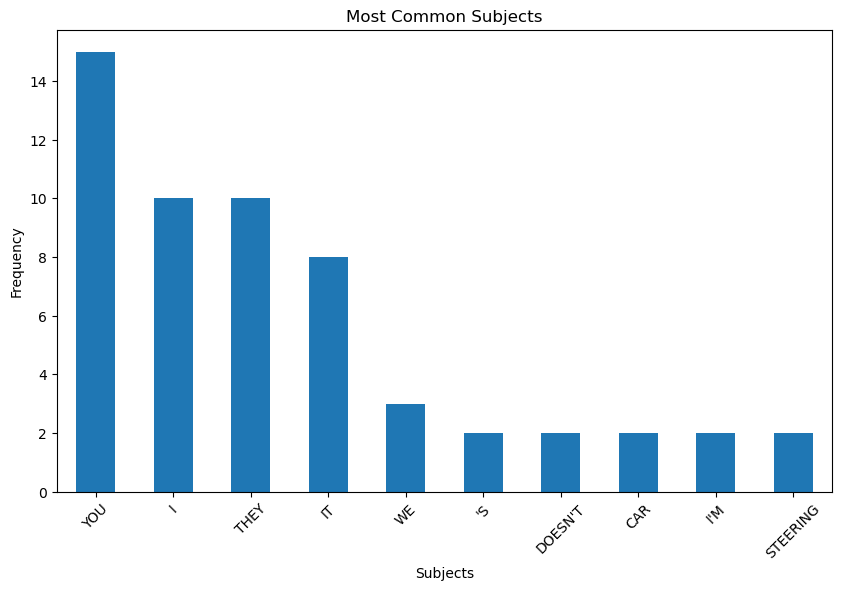

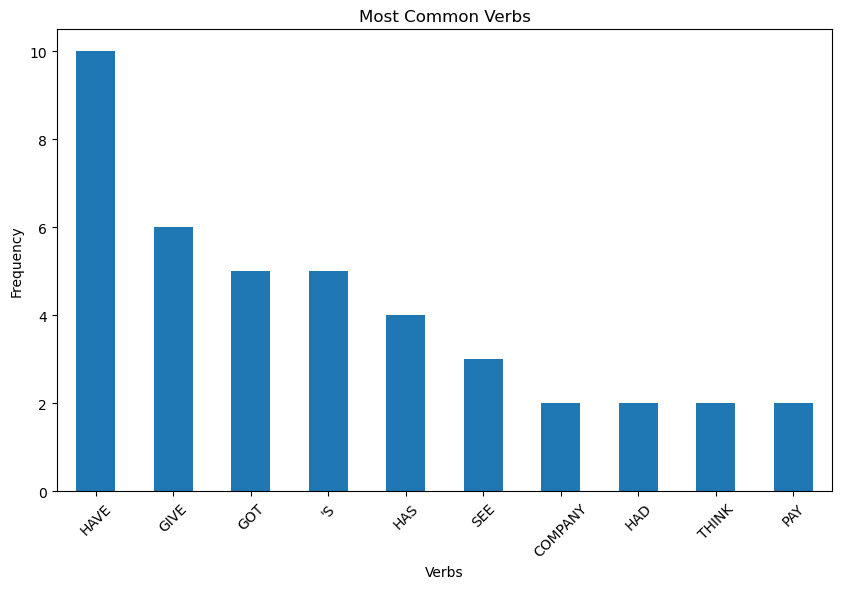

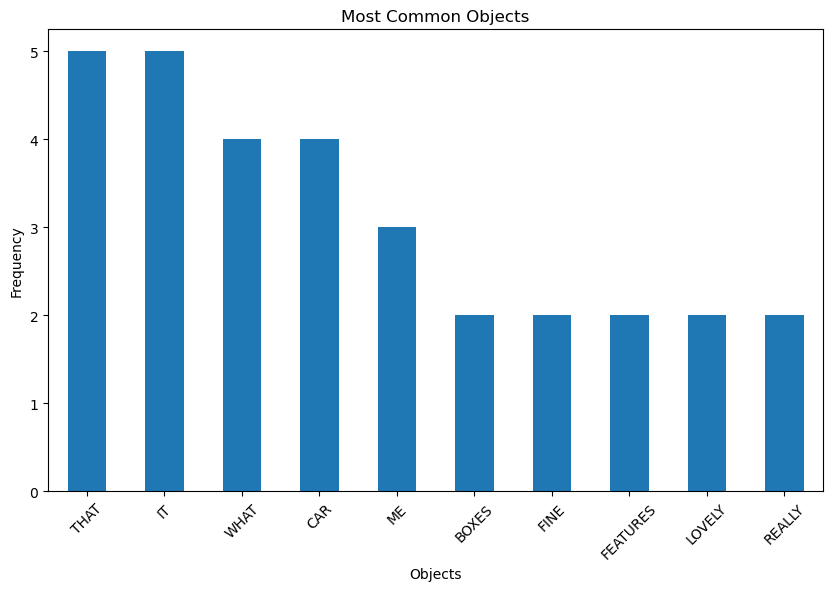

In [35]:
import matplotlib.pyplot as plt

# Plot the most common subjects
plt.figure(figsize=(10, 6))
most_common_subjects.plot(kind='bar')
plt.title("Most Common Subjects")
plt.xlabel("Subjects")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

# Plot the most common verbs
plt.figure(figsize=(10, 6))
most_common_verbs.plot(kind='bar')
plt.title("Most Common Verbs")
plt.xlabel("Verbs")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

# Plot the most common objects
plt.figure(figsize=(10, 6))
most_common_objects.plot(kind='bar')
plt.title("Most Common Objects")
plt.xlabel("Objects")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

The bar chart titled "Most Common Subjects" provides a visual representation of the frequency of different subjects in the analyzed text. The chart highlights that "YOU" is the most frequently used subject, appearing 15 times. This suggests that the text often addresses or refers to the reader or listener. "I" and "THEY" are also common subjects, each appearing 11 times, indicating a focus on personal experiences and actions of others. Other notable subjects include "IT," "WE," and "CAR," which show a mix of references to things, groups, and specific entities. This visual representation helps in quickly understanding the primary focus and actors within the text.

The bar chart of the "Most Common Verbs" highlights that "HAVE" is the most frequent verb, indicating a focus on possession or existence. "GIVE" and "GOT" follow, reflecting actions related to providing and receiving. The frequent use of contractions like "'S" suggests conversational language. This analysis helps identify the key actions and themes in the text, emphasizing interactions and possession.

The bar chart of the "Most Common Objects" indicates that "THAT" and "IT" are the most frequently occurring objects, each appearing 5 times, followed by "WHAT" and "CAR" with 4 occurrences each. Other notable objects include "ME" (3 times) and terms like "BOXES," "FINE," "FEATURES," "LOVELY," and "REALLY" (2 times each). This analysis highlights the prominence of general references and the specific focus on cars within the text.

In [ ]:
import networkx as nx

# Function to create a knowledge graph
def create_knowledge_graph(info):
    G = nx.DiGraph()

    for subject, verb, obj in info:
        G.add_edge(subject, obj, label=verb)

    return G

# Create the knowledge graph
G = create_knowledge_graph(info)

# Plot the knowledge graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10, font_weight="bold", edge_color="gray")
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
plt.title("Knowledge Graph")
plt.show()

The network graph illustrates the relationships between various words or phrases in our text. Each node represents a word or phrase, while the edges labeled in red indicate the type of relationship between them. The central nodes, such as "I," "WE," "YOU," "THEY," "DOESN'T," and "IT," highlight the primary subjects in your text and their connections to other words. This visual representation helps in understanding the structure and semantics of the language used, making it easier to identify key themes and how different elements are interrelated. Such graphs are useful for natural language processing tasks and for gaining insights into the text's overall composition.

## Conclusion

The analysis of converting speech data from a YouTube video into text and extracting
useful information from the transcribed text has provided valuable insights. By employing
various NLP techniques, such as text preprocessing, named entity recognition (NER),
dependency parsing, and information extraction, the report successfully demonstrates the
extraction of meaningful data from unstructured speech.

Key outcomes include the identification of significant entities such as names,
organizations, locations, and dates. The use of dependency parsing revealed the grammatical
relationships between words, further aiding in the extraction of structured information. The data
analysis and visualization, particularly through the knowledge graph, highlighted the central
themes and interconnections within the dataset.